In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold 
from keras_unet.models import custom_unet
import tensorflow as tf 
from tensorflow.keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded, dice_coef

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
os.chdir('..')

In [26]:
from preprocessing.get_ct_scan_information import build_train_test_df, get_cancer_pixel_count_df, add_cancer_pixel_info
from model.img_generator import DataGenerator2D, DataGenerator3D
from model.predict import predict_test_set
from model.metric_utils import calculate_iou_df,  calculate_iou 
from model.loss_functions import jaccard_distance_loss, focal_loss, dice_coef_loss, binary_focal_loss

## Create dataframes in the format and with the information required by the generator

### Create datframes with paths and depth for the images

In [4]:
data_path_source_dir = os.path.join('ml4h_proj1_colon_cancer_ct')

In [5]:
tr_df, x_ts_df = build_train_test_df(data_path_source_dir)

In [6]:
tr_df

x_tr_img_path  depth  \
index depth_i                                                             
001   0        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   
      1        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   
      2        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   
      3        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   
      4        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   
...                                                          ...    ...   
169   253      ml4h_proj1_colon_cancer_ct\imagesTr\colon_169....    258   
      254      ml4h_proj1_colon_cancer_ct\imagesTr\colon_169....    258   
      255      ml4h_proj1_colon_cancer_ct\imagesTr\colon_169....    258   
      256      ml4h_proj1_colon_cancer_ct\imagesTr\colon_169....    258   
      257      ml4h_proj1_colon_cancer_ct\imagesTr\colon_169....    258   

                                                   y_tr_img_path  
index depth_i                                                     
001   0        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....  
      1        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....  
      2        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....  
      3        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....  
      4        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....  
...                                                          ...  
169   253      ml4h_proj1_colon_cancer_ct\labelsTr\colon_169....  
      254      ml4h_proj1_colon_cancer_ct\labelsTr\colon_169....  
      255      ml4h_proj1_colon_cancer_ct\labelsTr\colon_169....  
      256      ml4h_proj1_colon_cancer_ct\labelsTr\colon_169....  
      257      ml4h_proj1_colon_cancer_ct\labelsTr\colon_169....  

[10162 rows x 3 columns]

In [7]:
x_ts_df

x_ts_img_path  depth
index depth_i                                                          
171   0        ml4h_proj1_colon_cancer_ct\imagesTs\colon_171....    119
      1        ml4h_proj1_colon_cancer_ct\imagesTs\colon_171....    119
      2        ml4h_proj1_colon_cancer_ct\imagesTs\colon_171....    119
      3        ml4h_proj1_colon_cancer_ct\imagesTs\colon_171....    119
      4        ml4h_proj1_colon_cancer_ct\imagesTs\colon_171....    119
...                                                          ...    ...
219   132      ml4h_proj1_colon_cancer_ct\imagesTs\colon_219....    137
      133      ml4h_proj1_colon_cancer_ct\imagesTs\colon_219....    137
      134      ml4h_proj1_colon_cancer_ct\imagesTs\colon_219....    137
      135      ml4h_proj1_colon_cancer_ct\imagesTs\colon_219....    137
      136      ml4h_proj1_colon_cancer_ct\imagesTs\colon_219....    137

[3324 rows x 2 columns]

Get information of which of the slices contain pixels labeled as cancer tissue from the images of the train set

In [21]:
cancer_pixels_df = get_cancer_pixel_count_df(full_tr_df=tr_df)

In [22]:
cancer_pixels_df

depth  cancer_pixel_area
index depth_i                          
001   51          60              841.0
      52          60              646.0
      53          60              296.0
005   44          98              278.0
      50          98              270.0
...              ...                ...
169   139        258              245.0
      140        258              228.0
      141        258              198.0
      142        258              153.0
      143        258              131.0

[1034 rows x 2 columns]

### Create CV folds for `tr_df`

let's go for 10 folds to have a 90/10 split. We can still only use only 3 or 5 to estimate the metrics

In [8]:
def generate_fold_dict(df_, n_folds=3, seed=123):
    
    img_num_idx_list = df_.index.levels[0]
    folder = KFold(n_splits=n_folds, random_state=seed, shuffle=True)
    df_fold_dict = dict()
    
    for i, (train_fold_i, holdout_i) in enumerate(folder.split(img_num_idx_list)):
        train_fold_i_idx = img_num_idx_list[train_fold_i]
        holdout_i_idx = img_num_idx_list[holdout_i]

        df_fold_dict[f'fold_{i}'] = {
            'train': df_.loc[pd.IndexSlice[train_fold_i_idx, :], :],
            'holdout': df_.loc[pd.IndexSlice[holdout_i_idx, :], :]
        }
        
    return df_fold_dict

In [9]:
tr_fold_df_dict =  generate_fold_dict(df_=tr_df, n_folds=10, seed=123) # 10 folds to have 90/10 split, but we can use only 3 or 5 to estimate the metrics

In [10]:
tr_fold_df_dict['fold_0']['train']

x_tr_img_path  depth  \
index depth_i                                                             
005   0        ml4h_proj1_colon_cancer_ct\imagesTr\colon_005....     98   
      1        ml4h_proj1_colon_cancer_ct\imagesTr\colon_005....     98   
      2        ml4h_proj1_colon_cancer_ct\imagesTr\colon_005....     98   
      3        ml4h_proj1_colon_cancer_ct\imagesTr\colon_005....     98   
      4        ml4h_proj1_colon_cancer_ct\imagesTr\colon_005....     98   
...                                                          ...    ...   
169   253      ml4h_proj1_colon_cancer_ct\imagesTr\colon_169....    258   
      254      ml4h_proj1_colon_cancer_ct\imagesTr\colon_169....    258   
      255      ml4h_proj1_colon_cancer_ct\imagesTr\colon_169....    258   
      256      ml4h_proj1_colon_cancer_ct\imagesTr\colon_169....    258   
      257      ml4h_proj1_colon_cancer_ct\imagesTr\colon_169....    258   

                                                   y_tr_img_path  
index depth_i                                                     
005   0        ml4h_proj1_colon_cancer_ct\labelsTr\colon_005....  
      1        ml4h_proj1_colon_cancer_ct\labelsTr\colon_005....  
      2        ml4h_proj1_colon_cancer_ct\labelsTr\colon_005....  
      3        ml4h_proj1_colon_cancer_ct\labelsTr\colon_005....  
      4        ml4h_proj1_colon_cancer_ct\labelsTr\colon_005....  
...                                                          ...  
169   253      ml4h_proj1_colon_cancer_ct\labelsTr\colon_169....  
      254      ml4h_proj1_colon_cancer_ct\labelsTr\colon_169....  
      255      ml4h_proj1_colon_cancer_ct\labelsTr\colon_169....  
      256      ml4h_proj1_colon_cancer_ct\labelsTr\colon_169....  
      257      ml4h_proj1_colon_cancer_ct\labelsTr\colon_169....  

[9202 rows x 3 columns]

In [11]:
tr_fold_df_dict['fold_0']['holdout']

x_tr_img_path  depth  \
index depth_i                                                             
001   0        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   
      1        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   
      2        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   
      3        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   
      4        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   
...                                                          ...    ...   
142   97       ml4h_proj1_colon_cancer_ct\imagesTr\colon_142....    102   
      98       ml4h_proj1_colon_cancer_ct\imagesTr\colon_142....    102   
      99       ml4h_proj1_colon_cancer_ct\imagesTr\colon_142....    102   
      100      ml4h_proj1_colon_cancer_ct\imagesTr\colon_142....    102   
      101      ml4h_proj1_colon_cancer_ct\imagesTr\colon_142....    102   

                                                   y_tr_img_path  
index depth_i                                                     
001   0        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....  
      1        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....  
      2        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....  
      3        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....  
      4        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....  
...                                                          ...  
142   97       ml4h_proj1_colon_cancer_ct\labelsTr\colon_142....  
      98       ml4h_proj1_colon_cancer_ct\labelsTr\colon_142....  
      99       ml4h_proj1_colon_cancer_ct\labelsTr\colon_142....  
      100      ml4h_proj1_colon_cancer_ct\labelsTr\colon_142....  
      101      ml4h_proj1_colon_cancer_ct\labelsTr\colon_142....  

[960 rows x 3 columns]

## Let's create a generator for the trainset

For the first fold

In [12]:
tr_fold_0_df = tr_fold_df_dict['fold_0']['train']
holdout_fold_0_df = tr_fold_df_dict['fold_0']['holdout']
print(tr_fold_0_df.shape[0])
print(holdout_fold_0_df.shape[0])

9202
960


In [23]:
tr_fold_0_df_cancer_info = add_cancer_pixel_info(
    df_=tr_fold_0_df.copy(), 
    cancer_pixels_df_=cancer_pixels_df)

holdout_fold_0_df_cancer_info = add_cancer_pixel_info(
    df_=holdout_fold_0_df.copy(), 
    cancer_pixels_df_=cancer_pixels_df)

In [24]:
tr_fold_0_df_cancer_info

x_tr_img_path  depth  \
index depth_i                                                             
005   0        ml4h_proj1_colon_cancer_ct\imagesTr\colon_005....     98   
      1        ml4h_proj1_colon_cancer_ct\imagesTr\colon_005....     98   
      2        ml4h_proj1_colon_cancer_ct\imagesTr\colon_005....     98   
      3        ml4h_proj1_colon_cancer_ct\imagesTr\colon_005....     98   
      4        ml4h_proj1_colon_cancer_ct\imagesTr\colon_005....     98   
...                                                          ...    ...   
169   253      ml4h_proj1_colon_cancer_ct\imagesTr\colon_169....    258   
      254      ml4h_proj1_colon_cancer_ct\imagesTr\colon_169....    258   
      255      ml4h_proj1_colon_cancer_ct\imagesTr\colon_169....    258   
      256      ml4h_proj1_colon_cancer_ct\imagesTr\colon_169....    258   
      257      ml4h_proj1_colon_cancer_ct\imagesTr\colon_169....    258   

                                                   y_tr_img_path  \
index depth_i                                                      
005   0        ml4h_proj1_colon_cancer_ct\labelsTr\colon_005....   
      1        ml4h_proj1_colon_cancer_ct\labelsTr\colon_005....   
      2        ml4h_proj1_colon_cancer_ct\labelsTr\colon_005....   
      3        ml4h_proj1_colon_cancer_ct\labelsTr\colon_005....   
      4        ml4h_proj1_colon_cancer_ct\labelsTr\colon_005....   
...                                                          ...   
169   253      ml4h_proj1_colon_cancer_ct\labelsTr\colon_169....   
      254      ml4h_proj1_colon_cancer_ct\labelsTr\colon_169....   
      255      ml4h_proj1_colon_cancer_ct\labelsTr\colon_169....   
      256      ml4h_proj1_colon_cancer_ct\labelsTr\colon_169....   
      257      ml4h_proj1_colon_cancer_ct\labelsTr\colon_169....   

               cancer_pixel_area  has_cancer_pixels  
index depth_i                                        
005   0                      0.0              False  
      1                      0.0              False  
      2                      0.0              False  
      3                      0.0              False  
      4                      0.0              False  
...                          ...                ...  
169   253                    0.0              False  
      254                    0.0              False  
      255                    0.0              False  
      256                    0.0              False  
      257                    0.0              False  

[9202 rows x 5 columns]

In [ ]:
resize_dim = (128, 128)

In [16]:
train_data_generator = DataGenerator2D(df=tr_fold_0_df_cancer_info, x_col='x_tr_img_path', y_col='y_tr_img_path', batch_size=64, 
                                       shuffle=True, shuffle_depths=True,
                                       class_sampling={'cancer_pixel': 2, 'not_cancer_pixel': 0.4},
                                       depth_class_col='has_cancer_pixels',
                                       resize_dim=resize_dim, hounsfield_min=-1000., hounsfield_max=400.,
                                       rotate_range=30, horizontal_flip=True, vertical_flip=True, random_crop=(0.8, 0.9), 
                                       shearing=None, gaussian_blur=None)

holdout_data_generator = DataGenerator2D(df=holdout_fold_0_df, x_col='x_tr_img_path', y_col='y_tr_img_path', batch_size=32, shuffle=False, 
                         resize_dim=resize_dim, hounsfield_min=-1000., hounsfield_max=400.,
                         rotate_range=None, horizontal_flip=False, vertical_flip=False)

## Let's create the Unet

In [17]:
num_epoch = 20
version = 2
split = '90_10_split'
lr = 1e-2
loss_used = 'binary_focal_loss'
augmentations = 'flips_rot_crop'
depth_shuffle = 'depth_shuffle'
imbalance_sampling = 'up_down_sampling_aggresive'

attepmt_name_dir = f'v{version}_{num_epoch}_lr_{lr}_epochs_{split}_{loss_used}_{augmentations}_{depth_shuffle}_{imbalance_sampling}' 
attepmt_name_dir = os.path.join('training_runs', 'juan', 'binary_loss_only', attepmt_name_dir)

os.makedirs(attepmt_name_dir, exist_ok=True)

In [ ]:
model = custom_unet(
    input_shape=resize_dim +(1,),
    use_batch_norm=True,
    num_classes=1,
    filters=32,
    dropout=0.2,
    output_activation='sigmoid')

In [25]:
model.summary();

SyntaxError: invalid syntax (<ipython-input-25-22b1e5bf7f6f>, line 1)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=lr), 
    loss=binary_focal_loss(gamma=2., alpha=0.7),
    metrics=[iou, iou_thresholded]
)

## Let's train the model

In [ ]:
def scheduler(epoch, lr):
  if epoch <= 3:
    return 1e-2
  
  elif epoch > 3 and epoch <= 12:
    return 1e-3

  elif epoch > 12 and epoch <= 25:
    return 1e-4

  else:
    return 1e-5 
      

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, verbose=1),
    #tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'./{attepmt_name_dir}' + '/model_sampling.{epoch:02d}-{val_loss:.2f}.h5', verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir=f'./{attepmt_name_dir}/logs_new'),
]

In [ ]:
model.fit(train_data_generator, validation_data=holdout_data_generator,
          epochs=num_epoch, callbacks=my_callbacks)

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
49/49 [==============================] - 246s 5s/step - loss: 0.3327 - iou: 0.0056 - iou_thresholded: 0.0012 - val_loss: 92.4987 - val_iou: 8.9171e-04 - val_iou_thresholded: 8.6925e-04

Epoch 00001: saving model to ./training_runs/juan/binary_loss_only/v2_20_lr_0.01_epochs_90_10_split_binary_focal_loss_flips_rot_crop_depth_shuffle_up_down_sampling_aggresive/model_sampling.01-92.50.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
49/49 [==============================] - 230s 5s/step - loss: 0.2627 - iou: 0.0073 - iou_thresholded: 0.0029 - val_loss: 5.7246 - val_iou: 0.0018 - val_iou_thresholded: 0.0034

Epoch 00002: saving model to ./training_runs/juan/binary_loss_only/v2_20_lr_0.01_epochs_90_10_split_binary_focal_loss_flips_rot_crop_depth_shuffle_up_down_sampling_aggresive/model_sampling.02-5.72.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.

In [ ]:
model.save(f'./{attepmt_name_dir}/end_of_training_version')

INFO:tensorflow:Assets written to: ./training_runs/juan/binary_loss_only/v2_20_lr_0.01_epochs_90_10_split_binary_focal_loss_flips_rot_crop_depth_shuffle_up_down_sampling_aggresive/end_of_training_version/assets


INFO:tensorflow:Assets written to: ./training_runs/juan/binary_loss_only/v2_20_lr_0.01_epochs_90_10_split_binary_focal_loss_flips_rot_crop_depth_shuffle_up_down_sampling_aggresive/end_of_training_version/assets


It was still decreasing, so let's keep it going for 10 more epochs with lr = 1e-3

In [ ]:
def scheduler(epoch, lr):
  if epoch <= 6:
    return 1e-4

  else:
    return 1e-5 

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'./{attepmt_name_dir}' + '/model_sampling_after_20_epochs.{epoch:02d}-{val_loss:.2f}.h5', verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir=f'./{attepmt_name_dir}/logs_new_after_20_epochs'),
]

In [ ]:
model.fit(train_data_generator, validation_data=holdout_data_generator,
          epochs=15, callbacks=my_callbacks)

Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
49/49 [==============================] - 231s 5s/step - loss: 0.1671 - iou: 0.0150 - iou_thresholded: 0.0678 - val_loss: 0.0737 - val_iou: 0.0034 - val_iou_thresholded: 0.4721

Epoch 00001: saving model to ./training_runs/juan/binary_loss_only/v2_20_lr_0.01_epochs_90_10_split_binary_focal_loss_flips_rot_crop_depth_shuffle_up_down_sampling_aggresive/model_sampling_after_20_epochs.01-0.07.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
49/49 [==============================] - 226s 5s/step - loss: 0.1697 - iou: 0.0157 - iou_thresholded: 0.0791 - val_loss: 0.0770 - val_iou: 0.0034 - val_iou_thresholded: 0.4442

Epoch 00002: saving model to ./training_runs/juan/binary_loss_only/v2_20_lr_0.01_epochs_90_10_split_binary_focal_loss_flips_rot_crop_depth_shuffle_up_down_sampling_aggresive/model_sampling_after_20_epochs.02-0.08.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reduc

In [ ]:
model.save(f'./{attepmt_name_dir}/end_of_training_version_after_20_epochs')

## Let's have it predict on the holdout data

In [33]:
path_best_performing_model = './training_runs/juan/binary_loss_only/v2_20_lr_0.01_epochs_90_10_split_binary_focal_loss_flips_rot_crop_depth_shuffle_up_down_sampling_aggresive/model_sampling_after_20_epochs.01-0.07.h5'
model = model = tf.keras.models.load_model(
    path_best_performing_model,
    custom_objects={'iou':iou, 'iou_thresholded': iou_thresholded,
                    'binary_focal_loss_fixed': binary_focal_loss(gamma=2., alpha=0.7)})

In [34]:
iou_df, y_list, y_pred_list = calculate_iou_df(df_=holdout_fold_0_df, img_dims=resize_dim,
                                               model_=model, pixel_threshold=0.0875,
                                               prediction_batch_size=1)

In [35]:
iou_df

,iou
index,
001,0.000410
008,0.000494
009,0.002252
015,0.001402
050,0.010875
096,0.000997
115,0.000766
126,0.002472
141,0.000197


In [36]:
iou_df.iou.mean()

0.002189098682335715

Check mins and max of the predicted pixels to set the ranges when looking for a good threshold

In [37]:
for y_i, y_pred_i in zip(y_list, y_pred_list):
  print(np.min(y_pred_i))

0.030156892
0.029989842
0.025689412
0.0336706
0.02383962
0.027364725
0.0306989
0.029627388
0.030454407
0.02299406


In [38]:
for y_i, y_pred_i in zip(y_list, y_pred_list):
  print(np.max(y_pred_i))

0.48196608
0.48553094
0.47879672
0.4602521
0.45907345
0.5226131
0.5405144
0.58602726
0.49476364
0.44040415


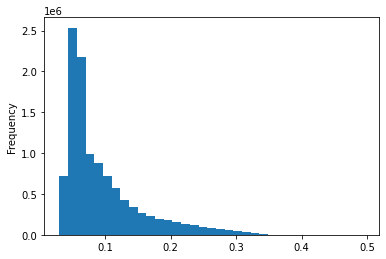

In [39]:
pd.Series(np.unique(y_pred_list[8])).plot.hist(bins=35)

Look for thresholds that have a better IoU

In [30]:
iou_list = list()
min_theshold = 0
max_threshold = 0.1
n_samples = 20
true_label_threshold = 0.5
result_list = list()

for threshold in np.random.uniform(min_theshold, max_threshold, n_samples):
  for y_i, y_pred_i in zip(y_list, y_pred_list):
    img_i_iou = calculate_iou(target=(y_i > true_label_threshold)*1,
                              prediction=(y_pred_i > threshold)*1)
    iou_list.append(img_i_iou)  

  result_list.append({'threshold': threshold, 'mean_iou':np.mean(img_i_iou)})

In [31]:
pd.DataFrame(result_list)

,threshold,mean_iou
0,0.007235,0.000497
1,0.084536,0.002068
2,0.023159,0.000497
3,0.065395,0.001315
4,0.023809,0.000497
5,0.025282,0.000497
6,0.093123,0.002542
7,0.014530,0.000497
8,0.077889,0.001772
9,0.088442,0.002278


In [32]:
pd.DataFrame(result_list).mean_iou.max()

0.0027813576130550984

# Check how a given trained model predicts

In [40]:
cancer_pixels_df = pd.read_pickle('cancer_pixels_df')
cancer_pixels_df.reset_index(inplace=True)
cancer_pixels_df['index'] = cancer_pixels_df.image_name.map(lambda str_: str_.split('.nii.gz')[0].split('colon_')[1])

### Predictions on holdout 

In [41]:
img_with_cancer_gen = DataGenerator2D(df=holdout_fold_0_df_cancer_info[holdout_fold_0_df_cancer_info.cancer_pixel_area > 0].sample(20),
                                      x_col='x_tr_img_path', y_col='y_tr_img_path', batch_size=4, num_classes=None, shuffle=False, resize_dim=resize_dim)

img_without_cancer_gen = DataGenerator2D(df=holdout_fold_0_df_cancer_info[holdout_fold_0_df_cancer_info.cancer_pixel_area == 0].sample(20),
                                     x_col='x_tr_img_path', y_col='y_tr_img_path', batch_size=4, num_classes=None, shuffle=False, resize_dim=resize_dim)

In [42]:
# Let's see how it predicts for images of cancer
for i, (X, y) in enumerate((img_with_cancer_gen)):
    print(f'X: {X.shape}')
    print(f'y: {y.shape}')

    y_pred = model.predict(X)
    print(y_pred.shape)
    
    for i in range(X.shape[0]):
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
        f.set_size_inches(20,20)

        ax1.imshow(X[i,:,:])
        ax1.set_title('Input image')
        
        ax2.imshow(y[i,:,:])
        ax2.set_title('Ground truth, target label')

        ax3.imshow(np.squeeze(y_pred[i,:,:]))
        ax3.set_title('Predicted by the model')
        
        plt.show()
        plt.close()

Output hidden; open in https://colab.research.google.com to view.

In [43]:
# Let's see how it predicts for images of cancer
for i, (X, y) in enumerate((img_without_cancer_gen)):
    print(f'X: {X.shape}')
    print(f'y: {y.shape}')

    y_pred = model.predict(X)
    print(y_pred.shape)
    
    for i in range(X.shape[0]):
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
        f.set_size_inches(20,20)

        ax1.imshow(X[i,:,:])
        ax1.set_title('Input image')
        
        ax2.imshow(y[i,:,:])
        ax2.set_title('Ground truth, target label')

        ax3.imshow(np.squeeze(y_pred[i,:,:]))
        ax3.set_title('Predicted by the model')
        
        plt.show()
        plt.close()
    

Output hidden; open in https://colab.research.google.com to view.

### Predictions on train 

In [ ]:
img_with_cancer_gen = DataGenerator2D(df=tr_fold_0_df_cancer_info[tr_fold_0_df_cancer_info.cancer_pixel_area > 0].sample(20),
                                      x_col='x_tr_img_path', y_col='y_tr_img_path', batch_size=4, num_classes=None, shuffle=False, resize_dim=resize_dim)

img_without_cancer_gen = DataGenerator2D(df=tr_fold_0_df_cancer_info[tr_fold_0_df_cancer_info.cancer_pixel_area==0].sample(20),
                                     x_col='x_tr_img_path', y_col='y_tr_img_path', batch_size=4, num_classes=None, shuffle=False, resize_dim=resize_dim)

In [ ]:
# Let's see how it predicts for images of cancer
for i, (X, y) in enumerate((img_with_cancer_gen)):
    print(f'X: {X.shape}')
    print(f'y: {y.shape}')

    y_pred = model.predict(X)
    print(y_pred.shape)
    
    for i in range(X.shape[0]):
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
        f.set_size_inches(20,20)

        ax1.imshow(X[i,:,:])
        ax1.set_title('Input image')
        
        ax2.imshow(y[i,:,:])
        ax2.set_title('Ground truth, target label')

        ax3.imshow(np.squeeze(y_pred[i,:,:]))
        ax3.set_title('Predicted by the model')
        
        plt.show()
        plt.close()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Let's see how it predicts for images of cancer
for i, (X, y) in enumerate((img_without_cancer_gen)):
    print(f'X: {X.shape}')
    print(f'y: {y.shape}')

    y_pred = model.predict(X)
    print(y_pred.shape)
    
    for i in range(X.shape[0]):
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
        f.set_size_inches(20,20)

        ax1.imshow(X[i,:,:])
        ax1.set_title('Input image')
        
        ax2.imshow(y[i,:,:])
        ax2.set_title('Ground truth, target label')

        ax3.imshow(np.squeeze(y_pred[i,:,:]))
        ax3.set_title('Predicted by the model')
        
        plt.show()
        plt.close()
    

Output hidden; open in https://colab.research.google.com to view.

# Let's obtain the predictions for the test set 

In [ ]:
test_dims = (512, 512)
pixel_threshold = 0.0875
prediction_batch_size = 32
output_dir = 'test_pred'
os.makedirs(output_dir, exist_ok=True)

In [27]:
predict_test_set(
    test_df_=x_ts_df,
    pred_dims=resize_dim,
    test_dims=test_dims,
    model_=model,
    pixel_threshold=pixel_threshold,
    prediction_batch_size=32,
    output_dir=output_dir
)

NameError: name 'preprocesing_params' is not defined